In [1]:
import cv2 as cv
import numpy as np
import torch
import random

from models.common import DetectMultiBackend
from matplotlib import pyplot as plt
from utils.augmentations import letterbox
from utils.general import non_max_suppression, scale_coords
from utils.plots import Annotator, colors
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
device = torch.device("cuda:0")
model = DetectMultiBackend("yolov5s6.pt", device=device)
_ = model.eval()
detect = model.model.model[-1]
names = model.model.names
num_anchors = len(detect.anchors)
anchors = [detect.anchor_grid[i][0,:,0,0].cpu().numpy().tolist() for i in range(num_anchors)]

stride = detect.stride.int().tolist()
max_stride = max(stride)

Fusing layers... 
YOLOv5s6 summary: 280 layers, 12612508 parameters, 0 gradients, 16.8 GFLOPs


(1080, 810, 3)


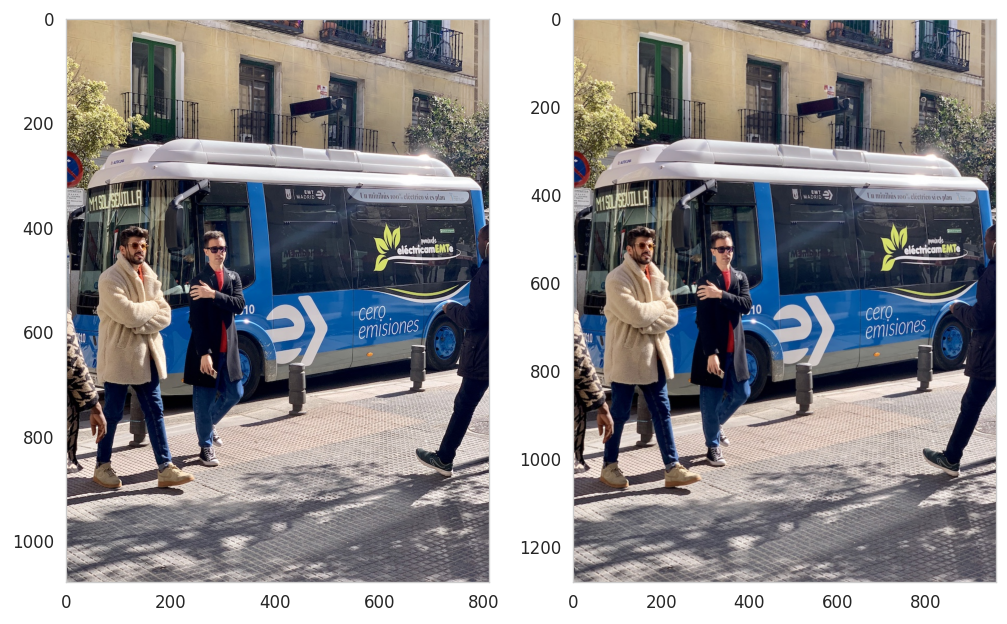

In [3]:
img = cv.imread("data/images/bus.jpg")
img0 = cv.cvtColor(img, cv.COLOR_BGR2RGB)
im0 = letterbox(img0, new_shape=(1280, 1280), stride=32)[0]
print(img.shape)

def plot_single_image(image, grid=0, call=False):
    plt.grid(grid)
    plt.imshow(image)
    if not call:
        plt.show()

def plot_multi_images(*images, grid=0):
    n = len(images)
    assert n, "Func needs at least 2 image as param!"
    row_colum = 100 + n * 10
    plt.figure(figsize=(5*n, 8),dpi=60)
    for i, image in enumerate(images):
        plt.subplot(row_colum + i + 1)
        plot_single_image(image, grid=grid, call=True)
    plt.show()

plot_multi_images(img0, im0)

In [4]:
def plot_detect_src(prediction, batch_inputs, img_source, labels, title=None):
    det = torch.ones_like(prediction[0], device=device)
    det.copy_(prediction[0])
    det[:, :4] = scale_coords(batch_inputs.shape[2:], det[:, :4], img_source.shape).round()
    annotator = Annotator(img_source.copy())
    for *xyxy, conf, cls in reversed(det):
        c = int(cls)
        label = f'ind{c}:{labels[c]} {conf*100:.2f}'
        print([int(i.cpu().numpy()) for i in xyxy], label)
        annotator.box_label(xyxy, label, color=colors(c, True))
    detect_img = annotator.result()
    plt.figure(figsize=(5, 5), dpi=80)
    if title is not None:
        plt.title(title)
    plot_single_image(detect_img)


im = np.expand_dims(im0.transpose(2,0,1), 0) / 255.0
batch_in = torch.Tensor(im).to(device).float()
out, train_out = model(batch_in, augment=False, val=True)
pred = non_max_suppression(out, 0.4, 0.45)

Detect:
[0, 554, 76, 876] ind0:person 56.62
[224, 411, 347, 858] ind0:person 88.49
[51, 401, 244, 900] ind0:person 90.00
[14, 223, 803, 748] ind5:bus 91.91
[665, 401, 809, 879] ind0:person 93.33


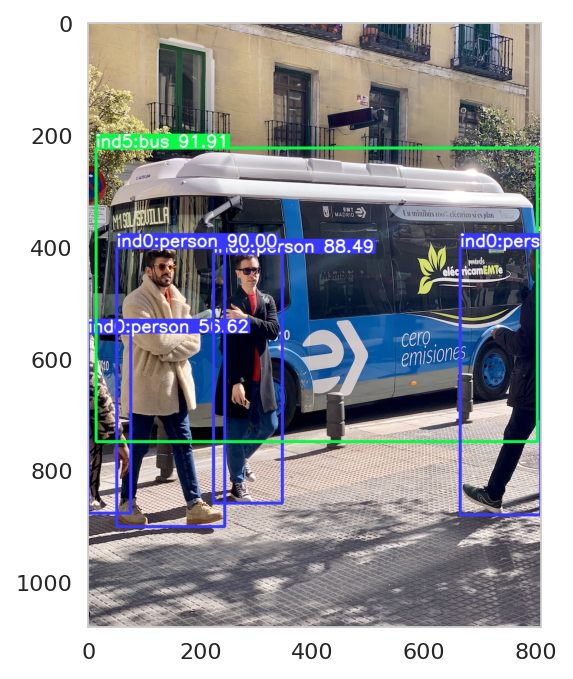

In [5]:
print("Detect:")
plot_detect_src(pred, batch_in, img0, names)

Batch_in & Head[3][0,4]:Conf

[0, 657, 90, 1039] ind0:person 56.62
[266, 487, 411, 1016] ind0:person 88.49
[60, 475, 289, 1067] ind0:person 90.00
[17, 264, 952, 886] ind5:bus 91.91
[788, 475, 959, 1041] ind0:person 93.33


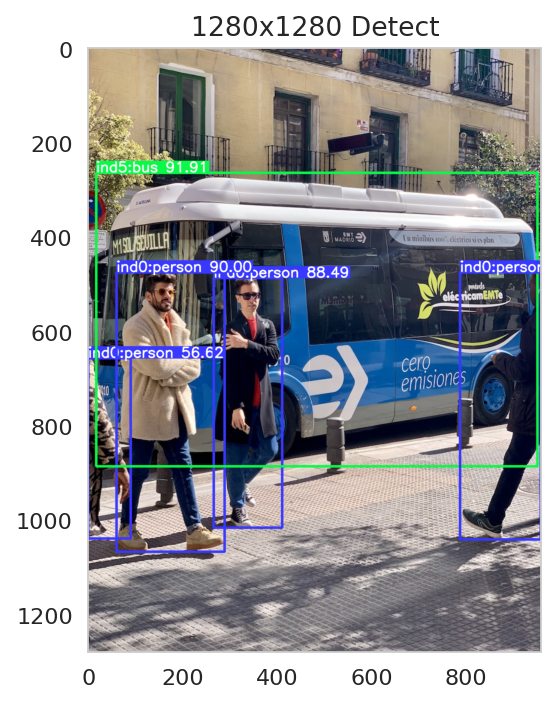

In [6]:
print("Batch_in & Head[3][0,4]:Conf\n")
plot_detect_src(pred, batch_in, im0, names, title="1280x1280 Detect")

Out: torch.Size([1, 76500, 85])
Head:4 Anchors:3 Number of Classes:80
Slice size: [57600, 14400, 3600, 900]  -> Sum = 76500
Output size 76500
[0, 57600, 72000, 75600, 76500]
torch.Size([57600, 85]) --> [3, 160, 120, 85]
torch.Size([14400, 85]) --> [3, 80, 60, 85]
torch.Size([3600, 85]) --> [3, 40, 30, 85]
torch.Size([900, 85]) --> [3, 20, 15, 85]
4 Heads: torch.Size([3, 85, 160, 120]) torch.Size([3, 85, 80, 60]) torch.Size([3, 85, 40, 30]) torch.Size([3, 85, 20, 15])


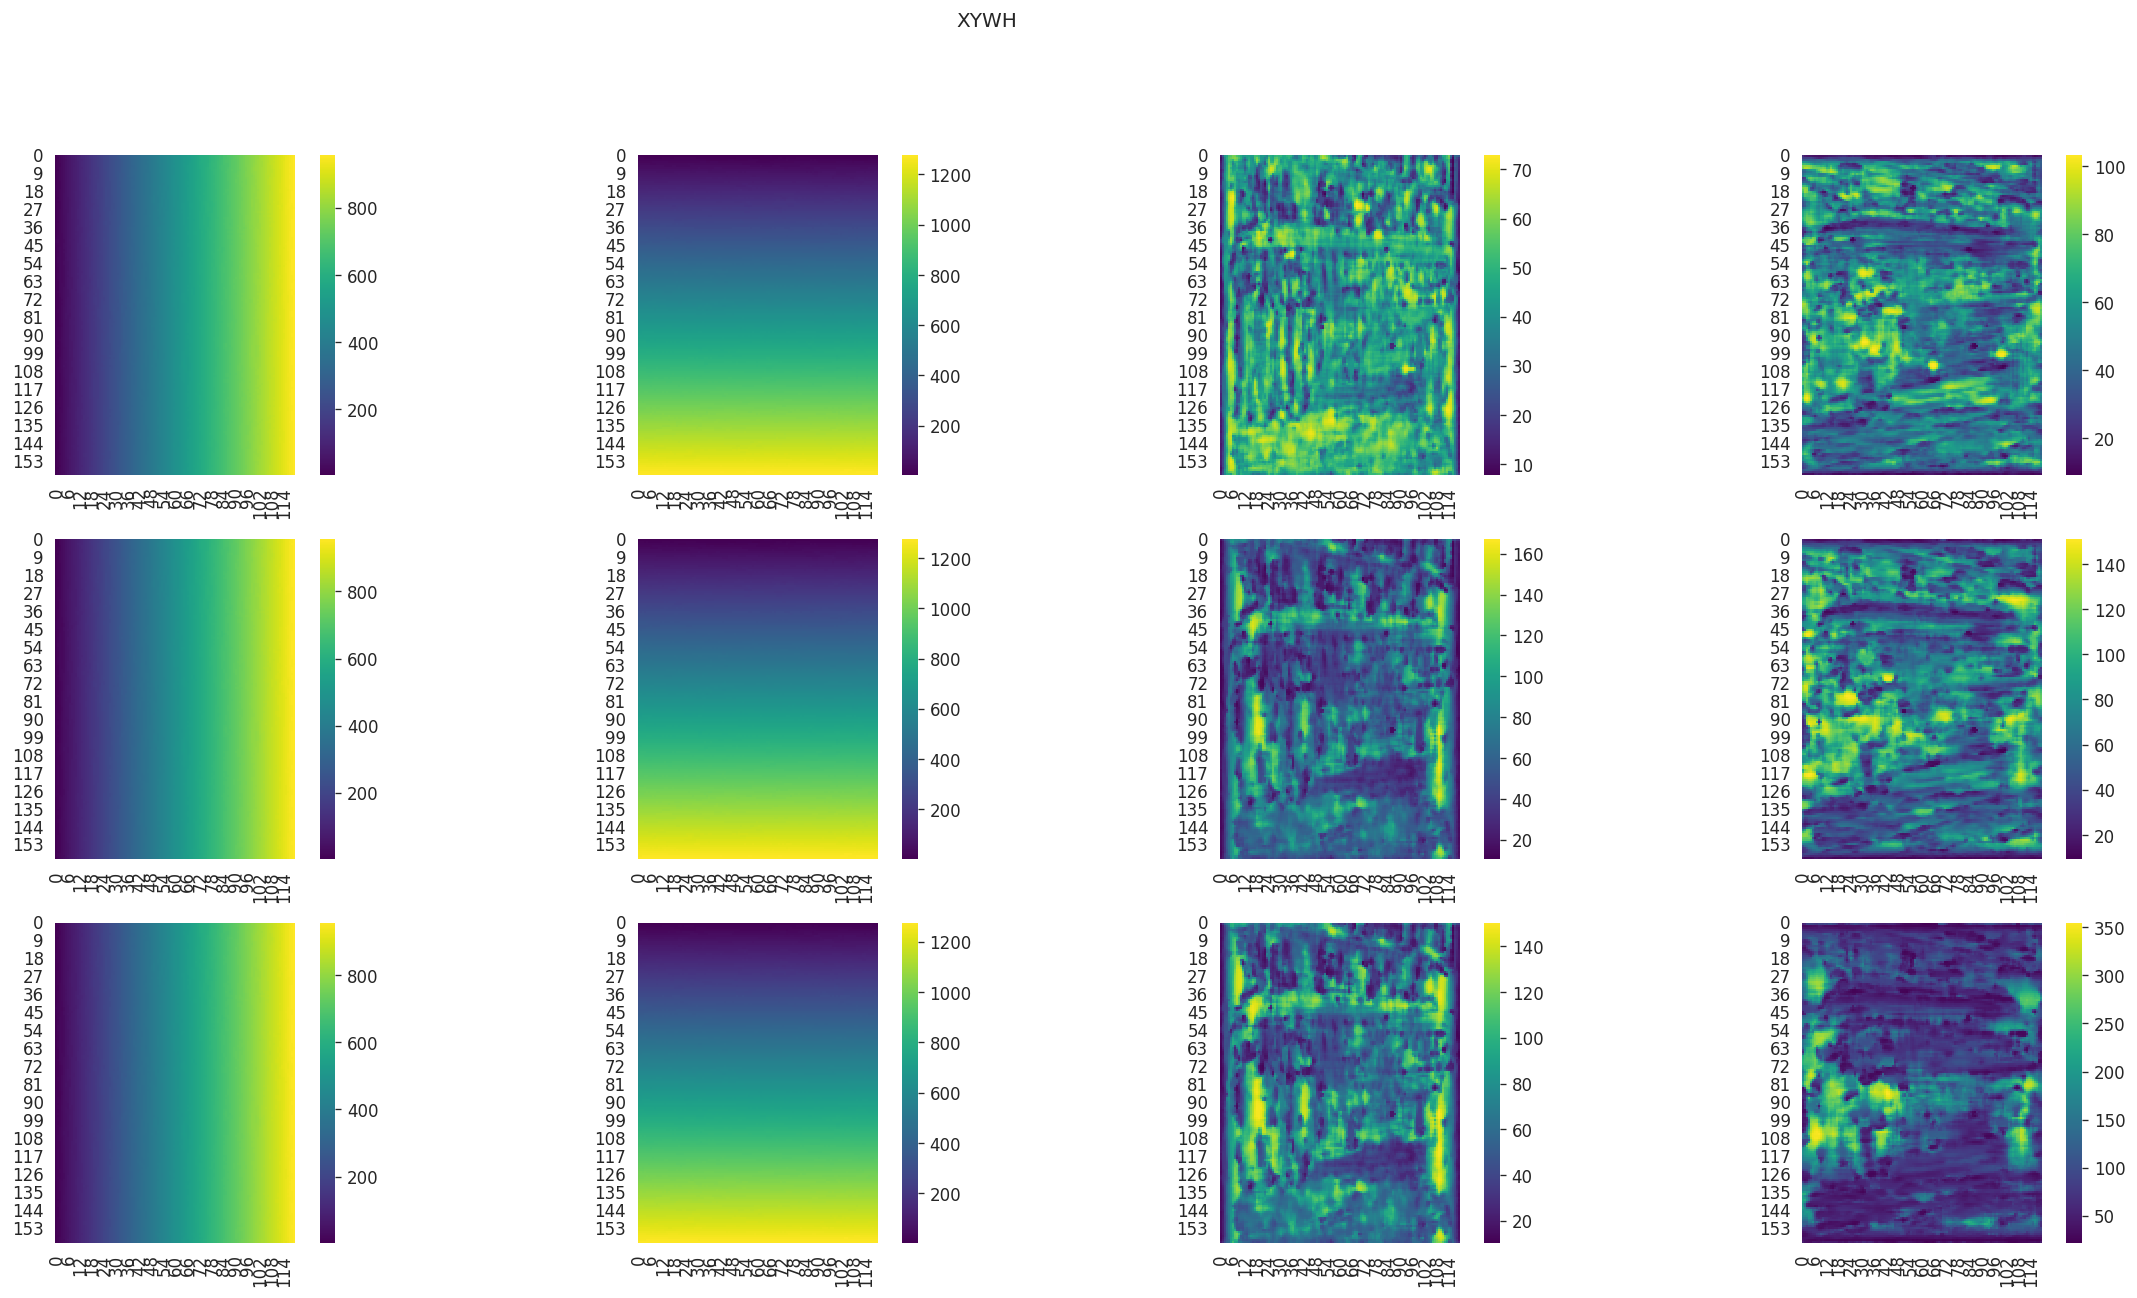

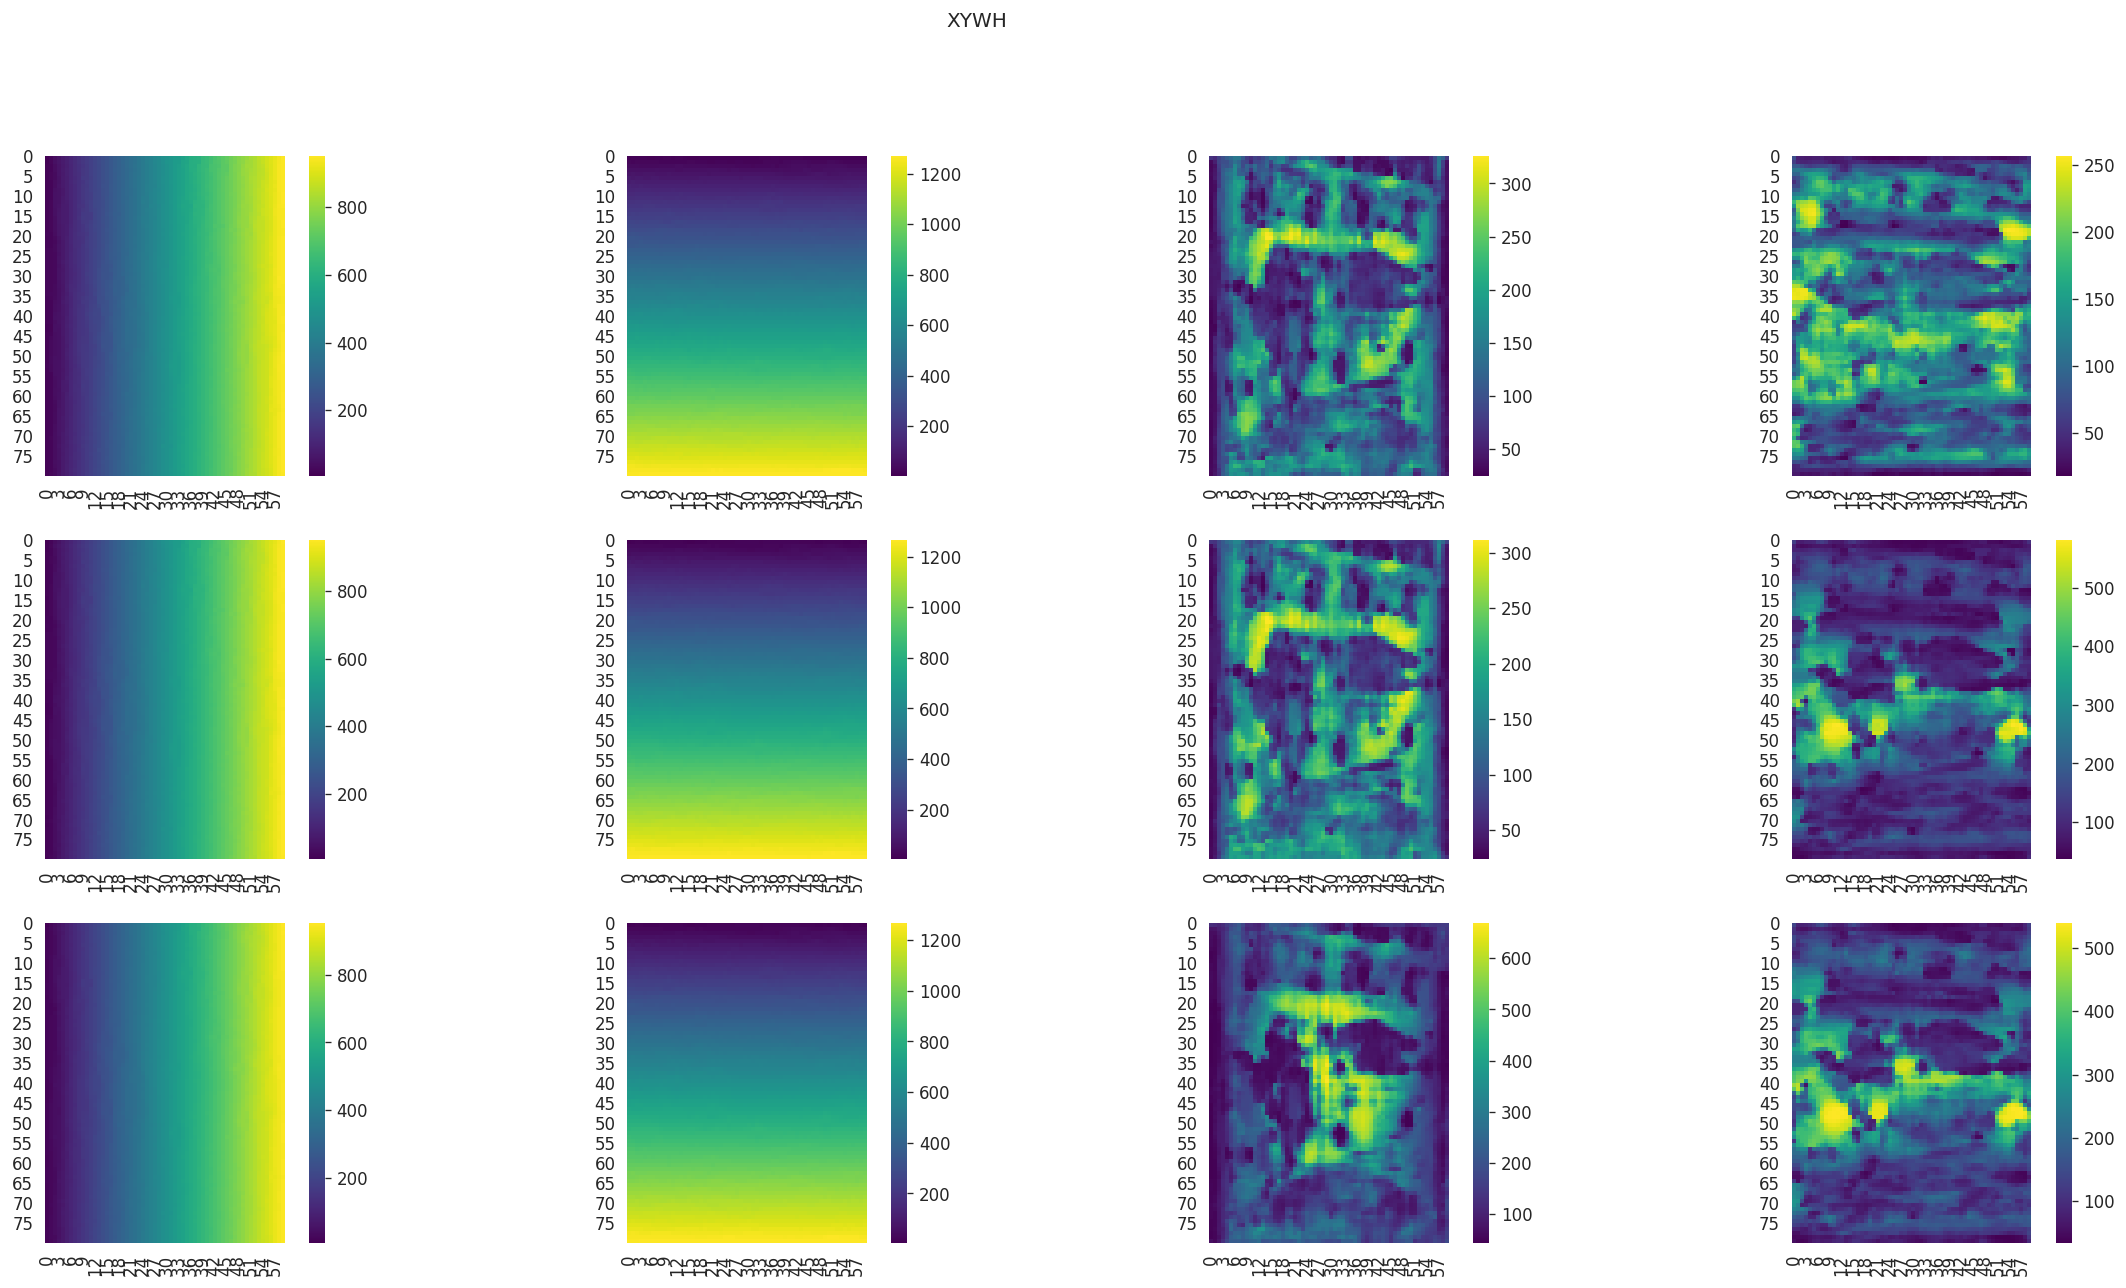

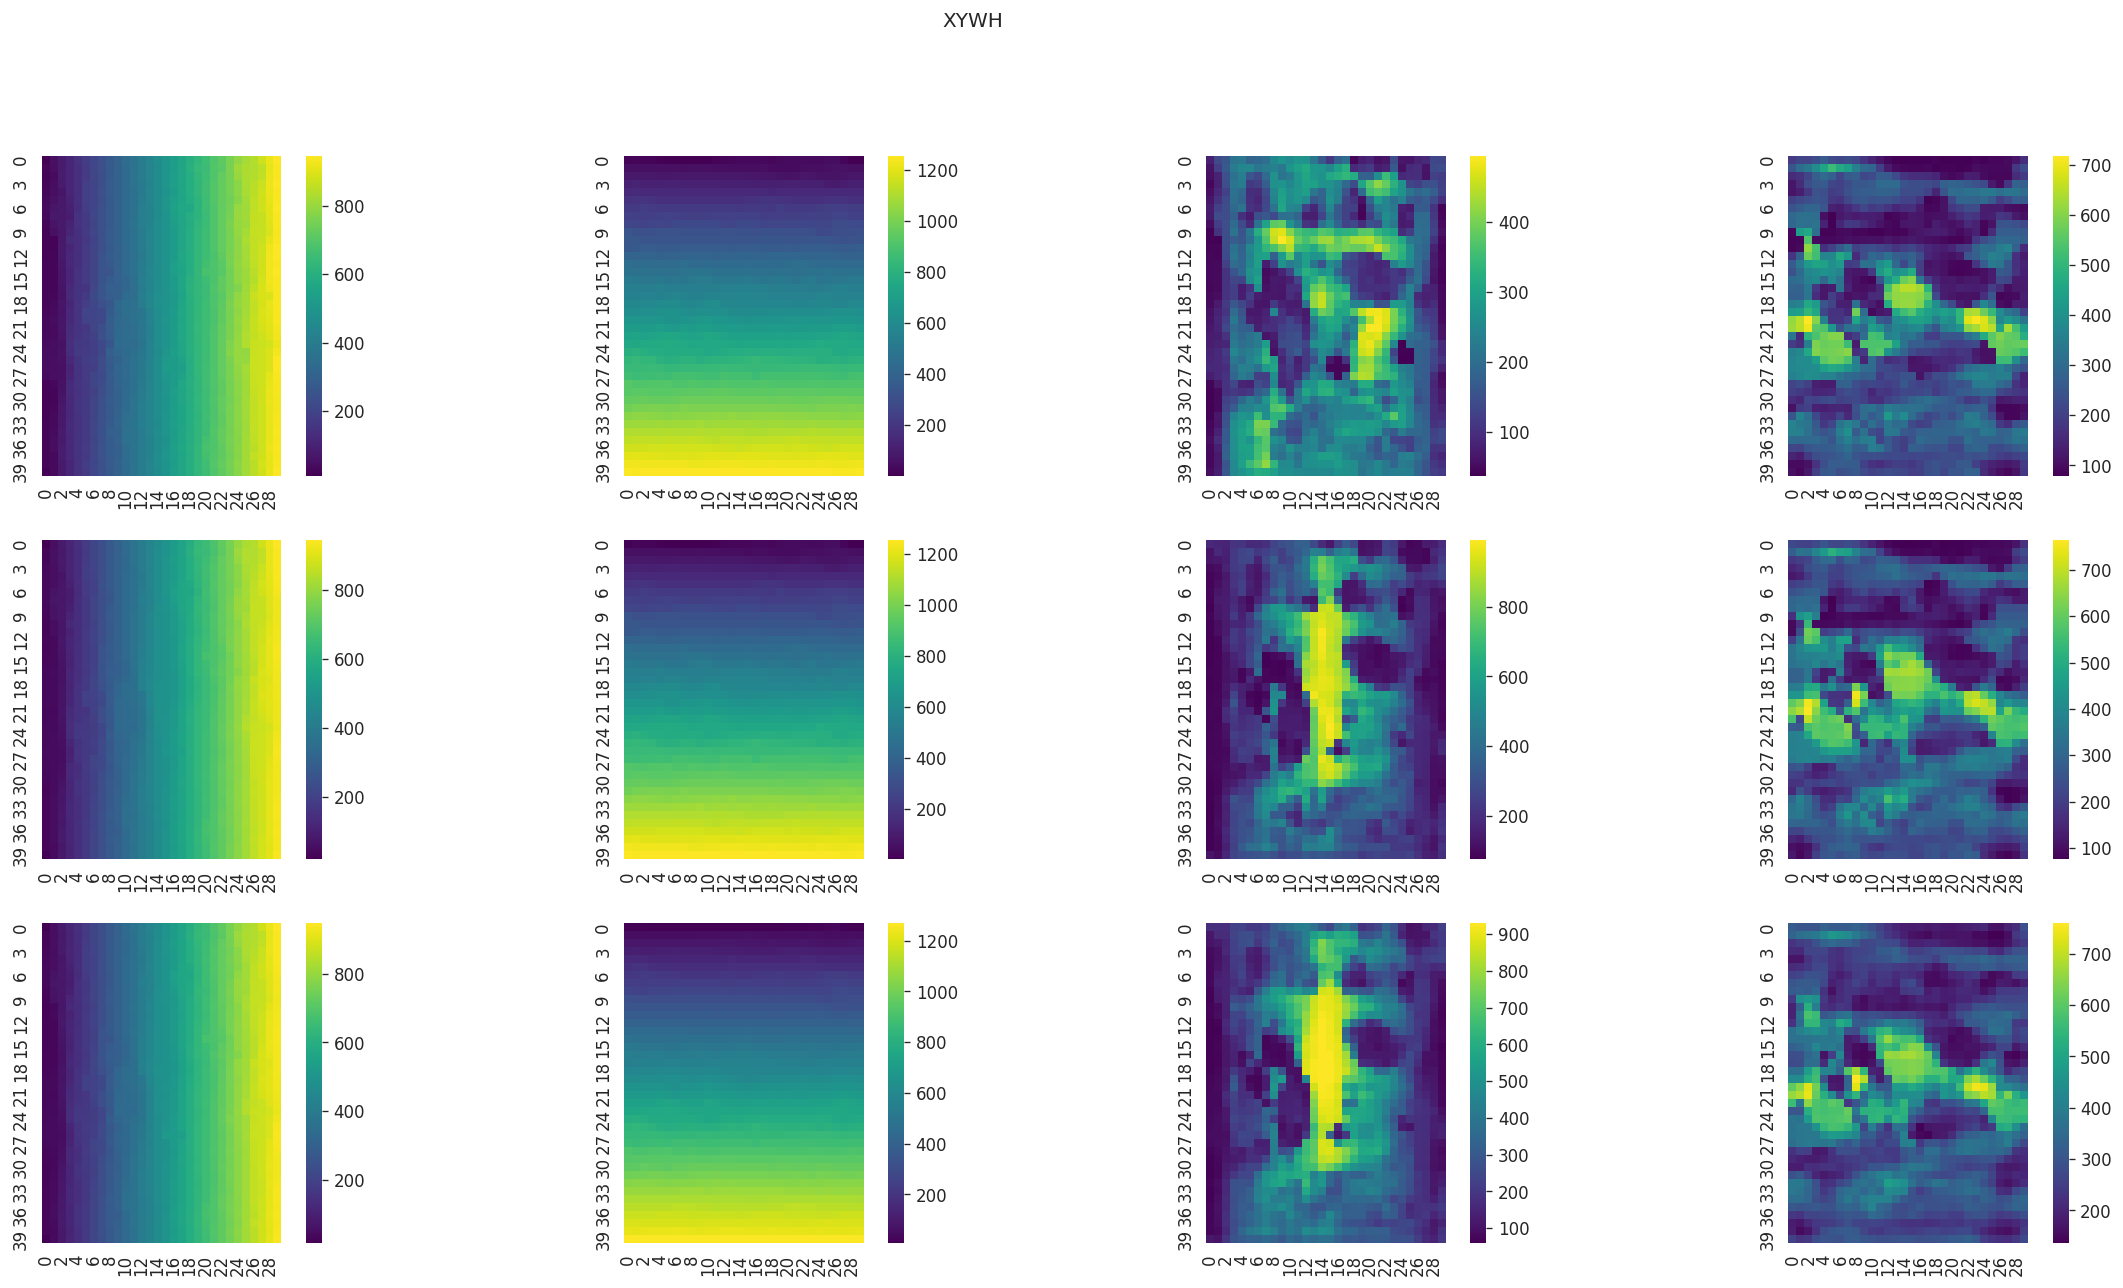

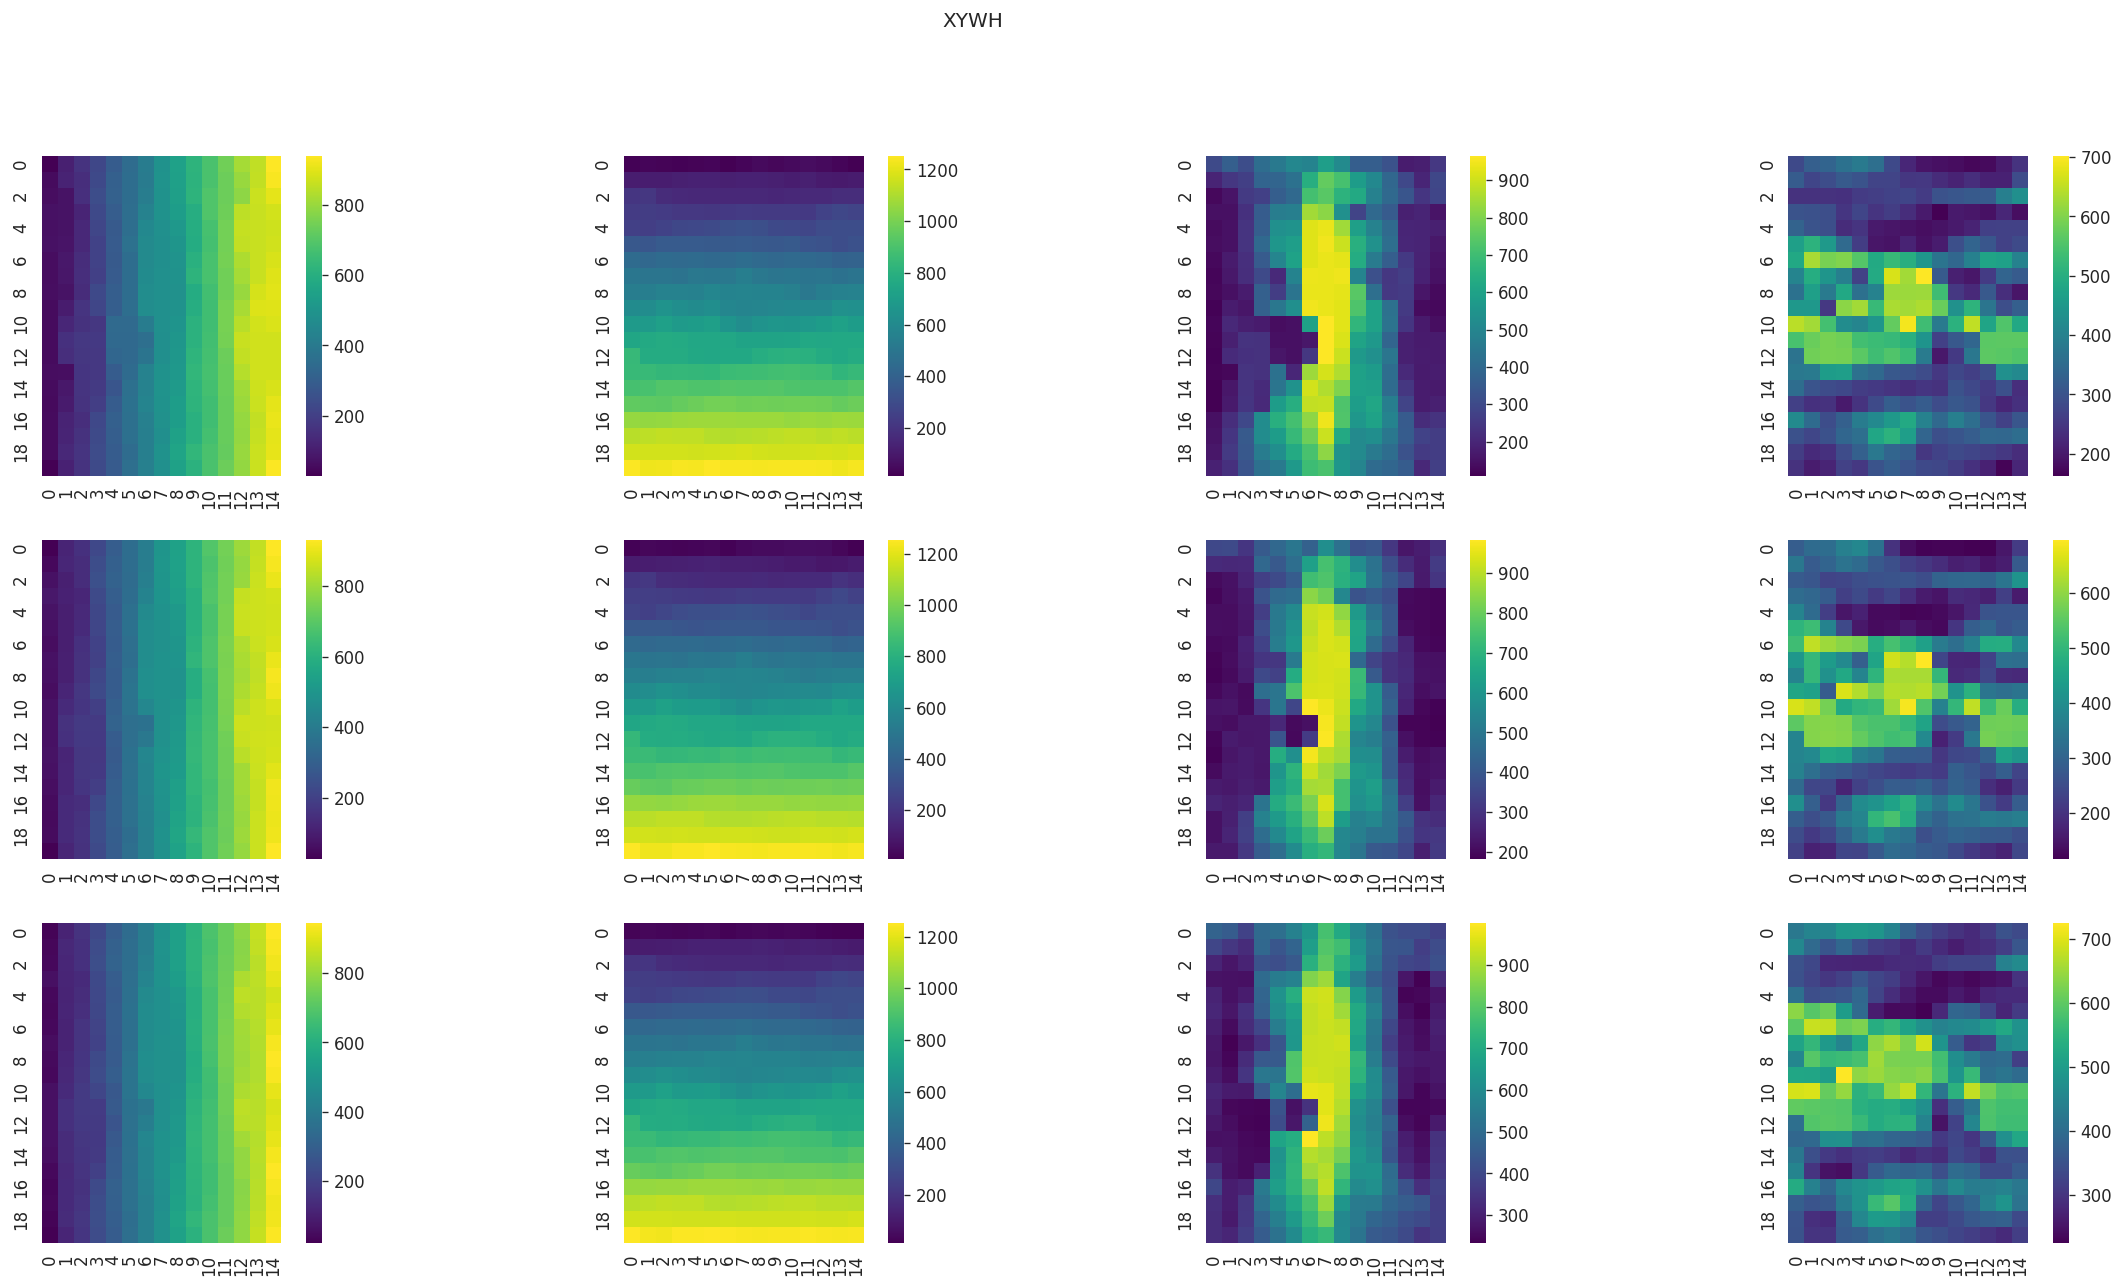

In [7]:
nb, channels, height, width = batch_in.shape # number of batches, channels, HW
nl = len(anchors)  # number of detection layers:4
na = len(anchors[0])  #number of anchors per head
nc = len(names)
#out_shape : [batch, sum(n * grid_size ** 2) of each head, no]
print("Out:", out.shape)
no = out.shape[2] # Num of Classes + 5 : XYWH, Confidence
assert nc == out.shape[2]-5, f'Number of Classes({nc}) Does NOT Match with output size!'

slice_size = [(height // stride_i) * (width // stride_i) * na for stride_i in stride]

print(f"Head:{nl}", f"Anchors:{na}", f"Number of Classes:{nc}")
print("Slice size:", slice_size, " -> Sum =", sum(slice_size))
print("Output size", out.shape[1])
assert sum(slice_size) == out.shape[1]

slice_index = [0]
for i in slice_size:
    slice_index.append(i + slice_index[-1])
print(slice_index)
head = []
for i in range(len(slice_index) - 1):
    layer = out[:, slice_index[i]:slice_index[i+1], :].squeeze()
    new_shape = [na, height // stride[i], width // stride[i], no]
    print(layer.shape[:], "-->", new_shape)
    layer = layer.reshape(new_shape)
    head.append(layer.permute(0, 3, 1, 2))
print(len(head), "Heads:", *(i.shape for i in head))

def plot_single_heatmap(array, cmap='viridis', title=None, dpi=60):
    plt.figure(figsize=(5, 5), dpi=dpi)
    if title:
        plt.title(title)
    if isinstance(array, torch.Tensor):
        array = array.cpu().numpy()
    sns.heatmap(array, square=True, cmap=cmap)


def plot_multi_heatmap(*arrays, cmap='viridis', title=None, row=None, col=None):
    n = len(arrays)
    if row is not None:
        col = int(np.ceil(n / row))
    else:
        if col is not None:
            row = int(np.ceil(n / col))
        else:
            row = int(np.sqrt(n))
            col = int(np.ceil(n / row))

    fig, ax = plt.subplots(row, col, figsize=(6*col, 4*row), dpi = 60)
    if title is not None: fig.suptitle(title)

    for i, array in enumerate(arrays):
        if isinstance(array, torch.Tensor):
            array = array.cpu().numpy()
        r = i // col
        c = i % col
        axi = ax[r, c] if row > 1 else ax[c]
        sns.heatmap(array, square=True, cmap=cmap, ax=axi)
    plt.show()

for head_index in range(nl):
    plot_multi_heatmap(*(head[head_index][i,j] for i in range(3) for j in range(4)), title="XYWH")

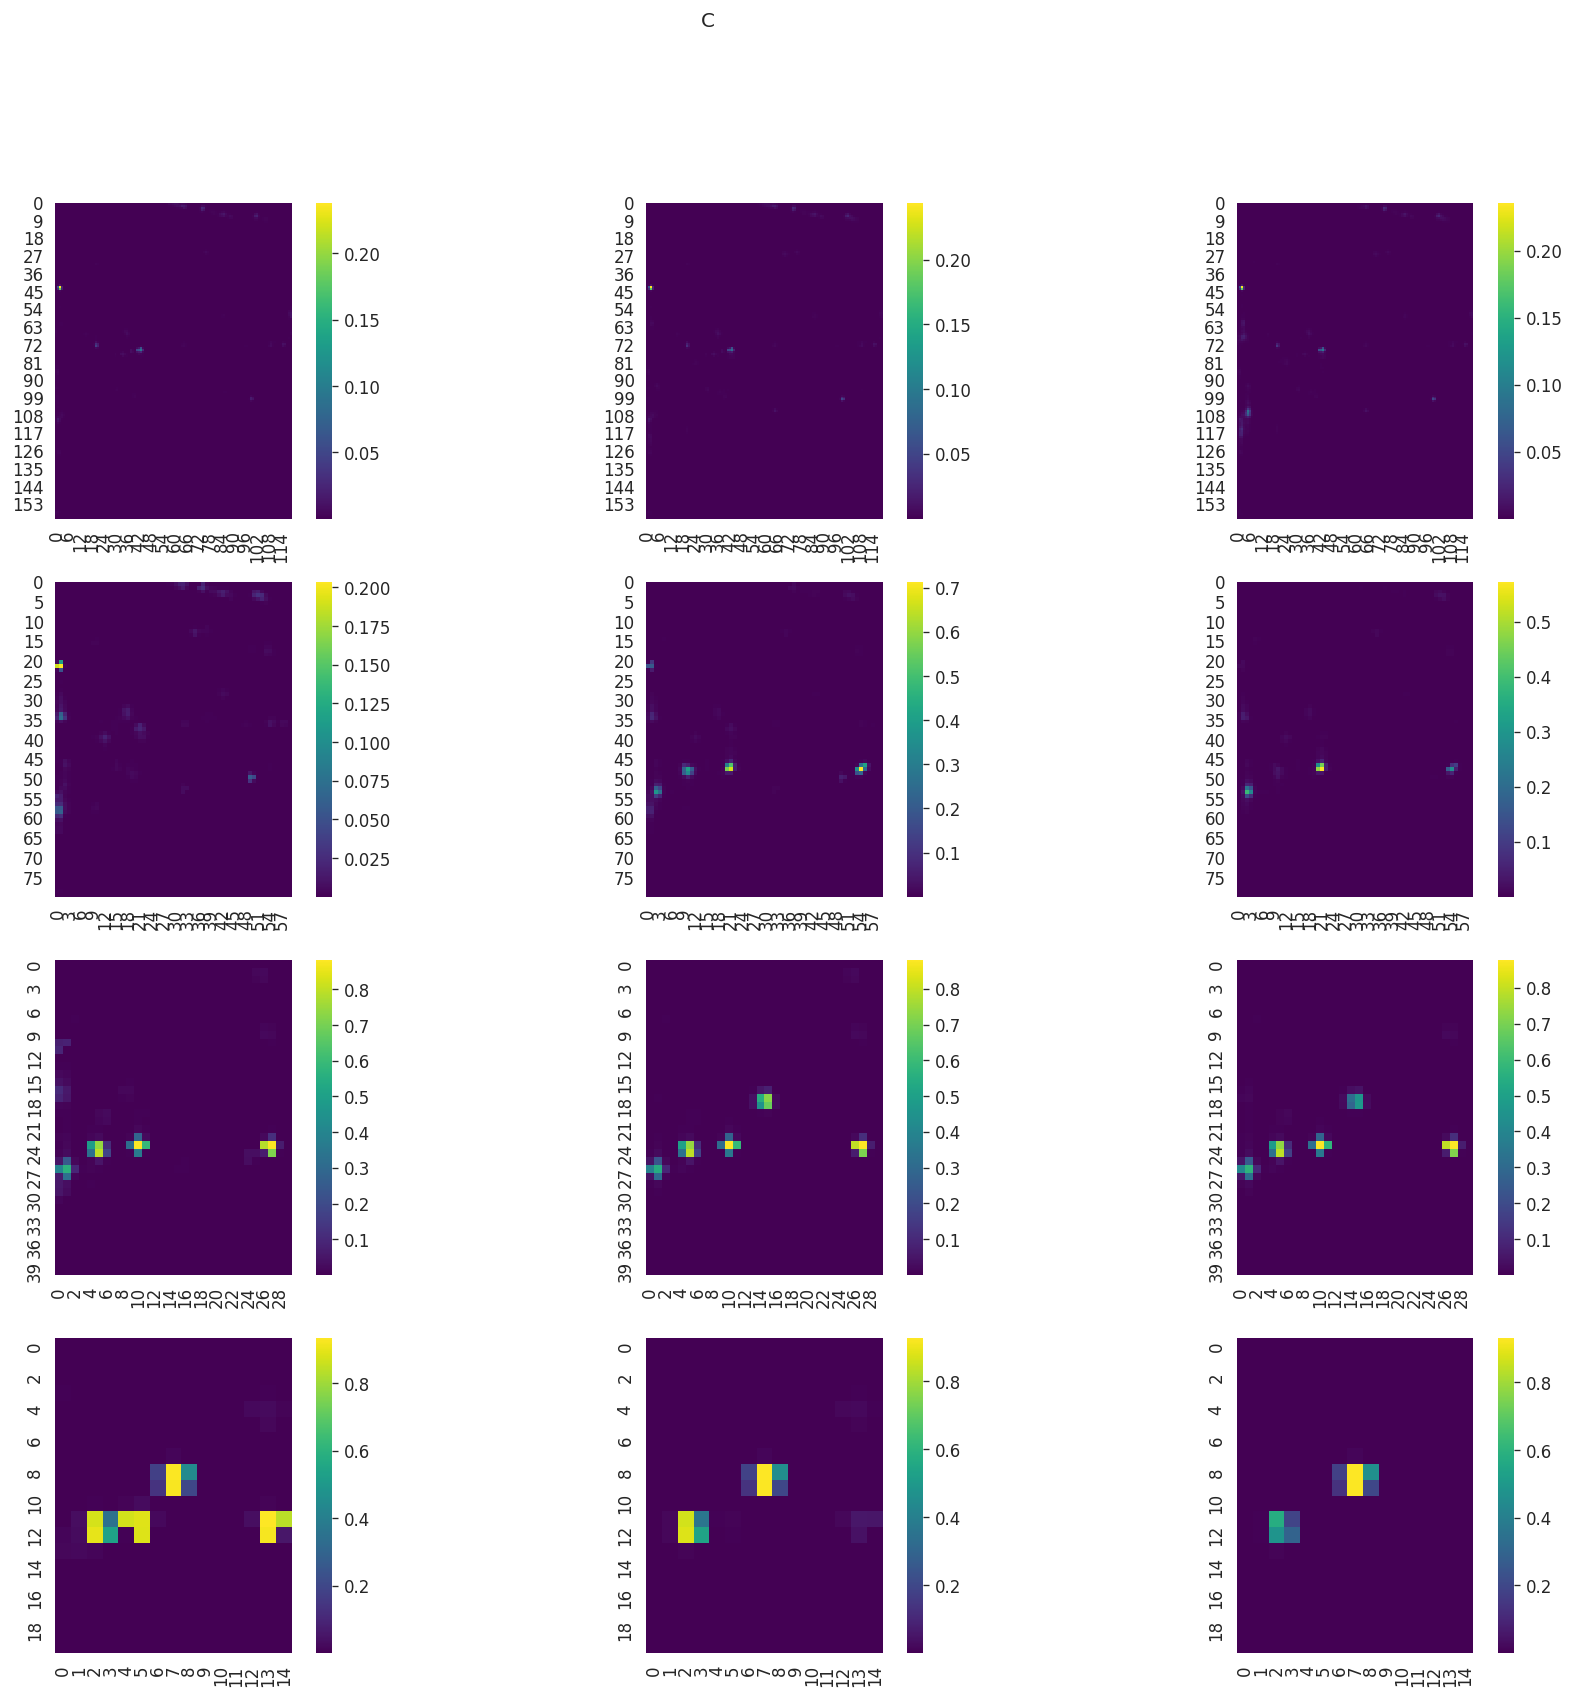

In [8]:
plot_multi_heatmap(*(head[i][j,4] for i in range(nl) for j in range(na)), col=na, title="C")

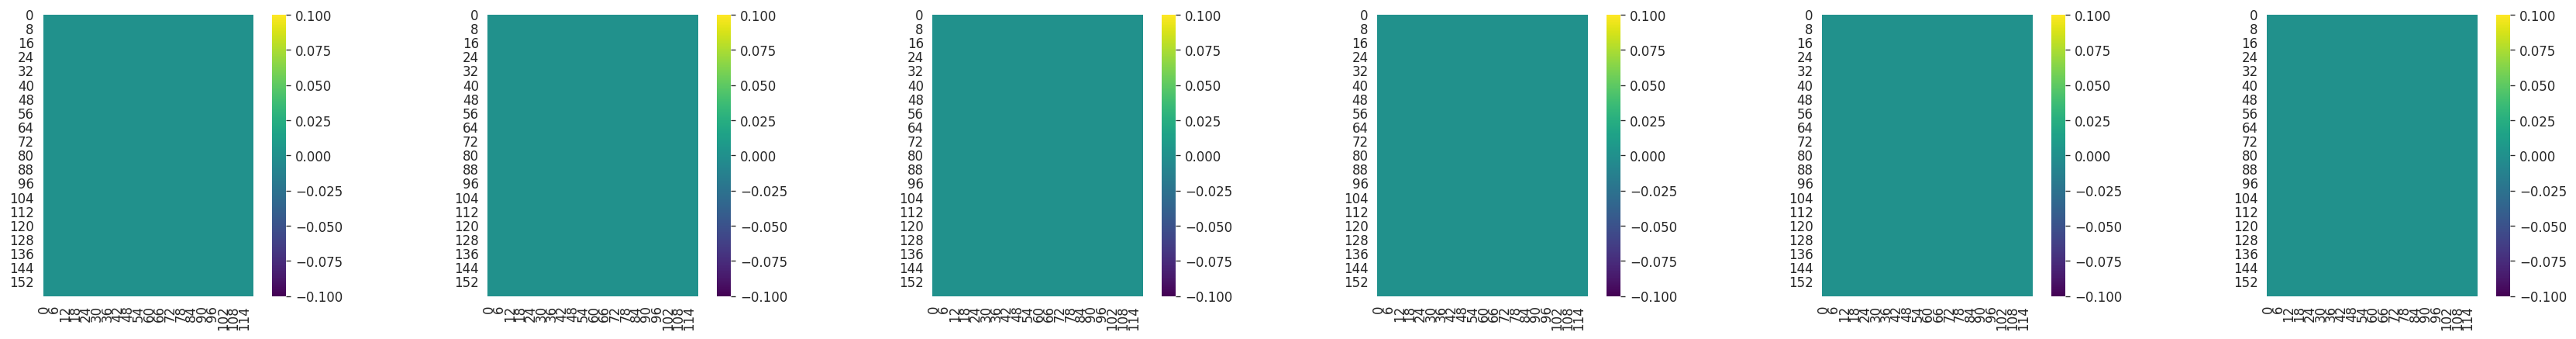

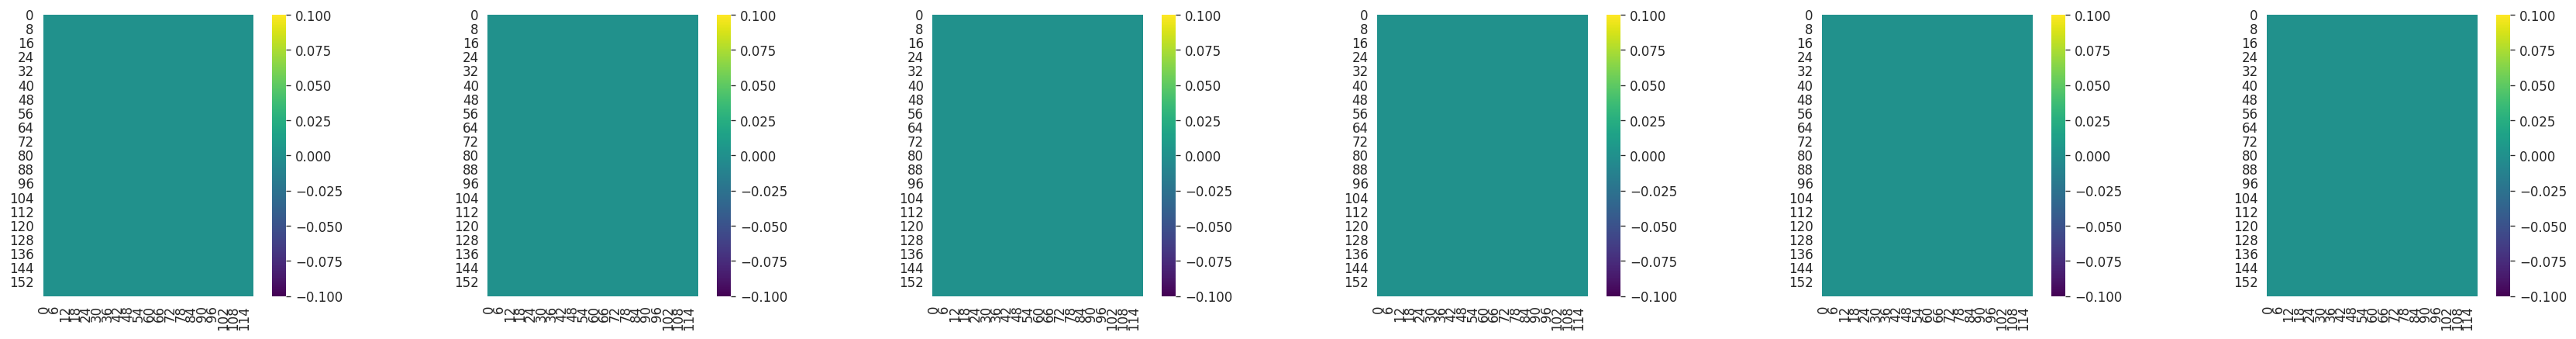

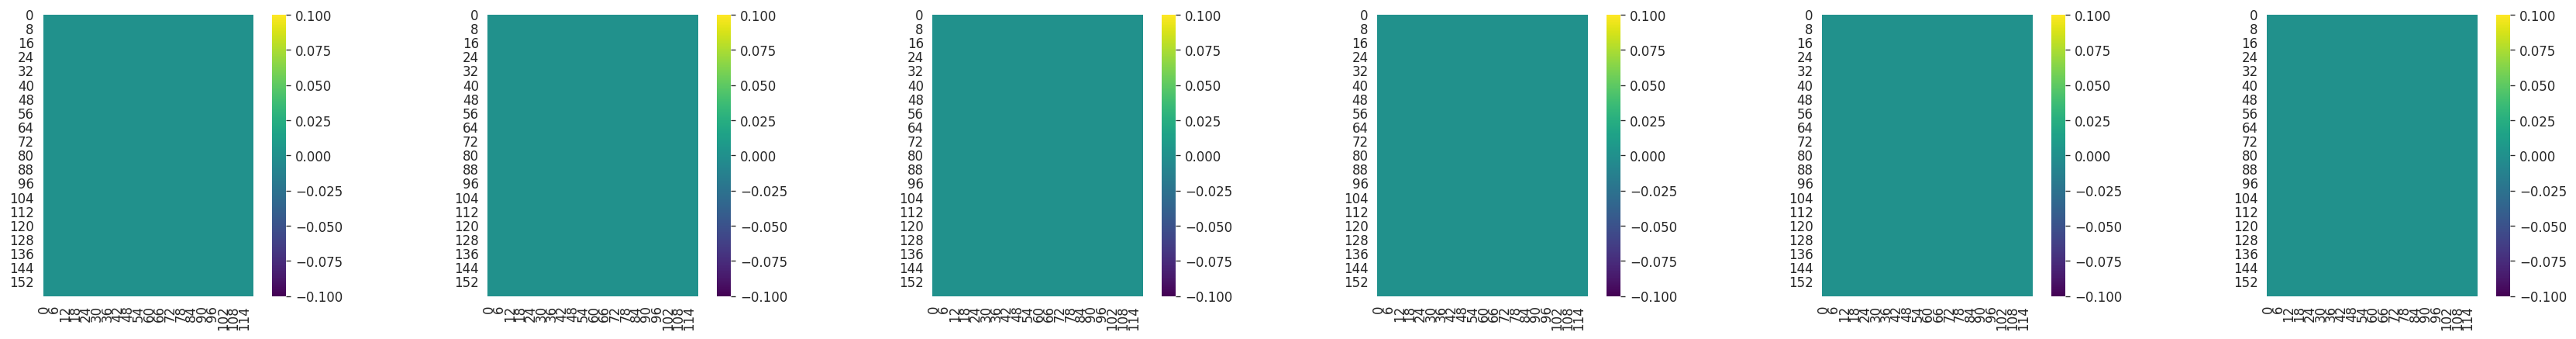

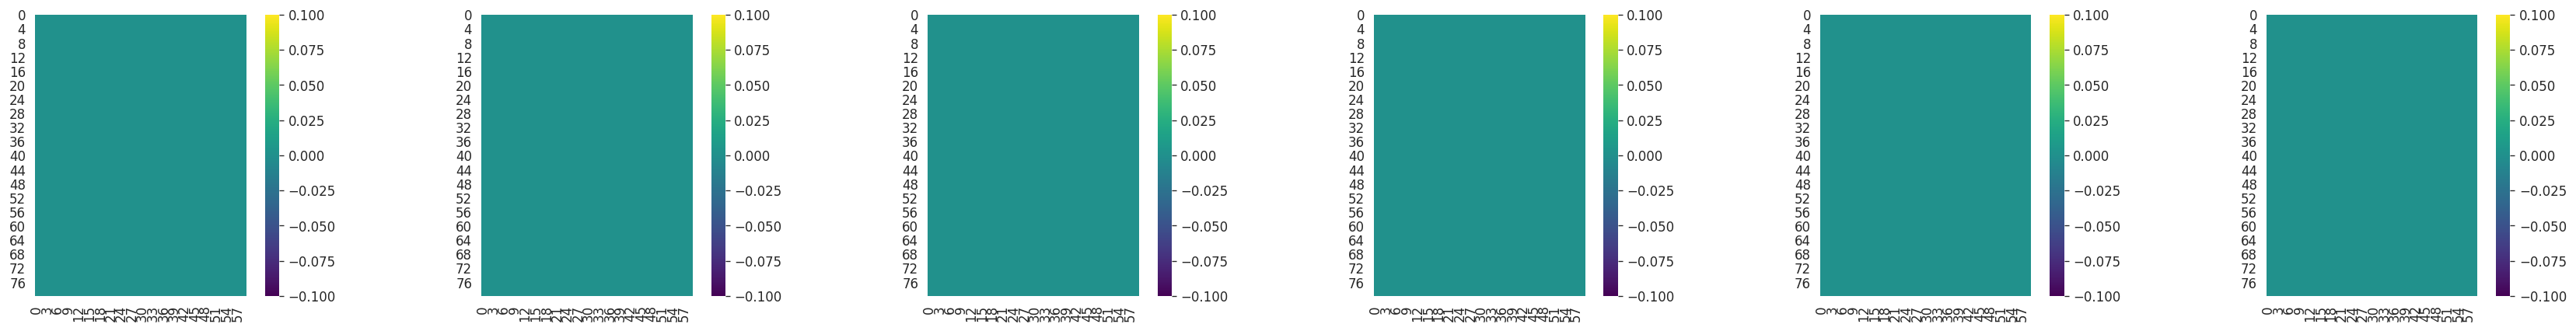

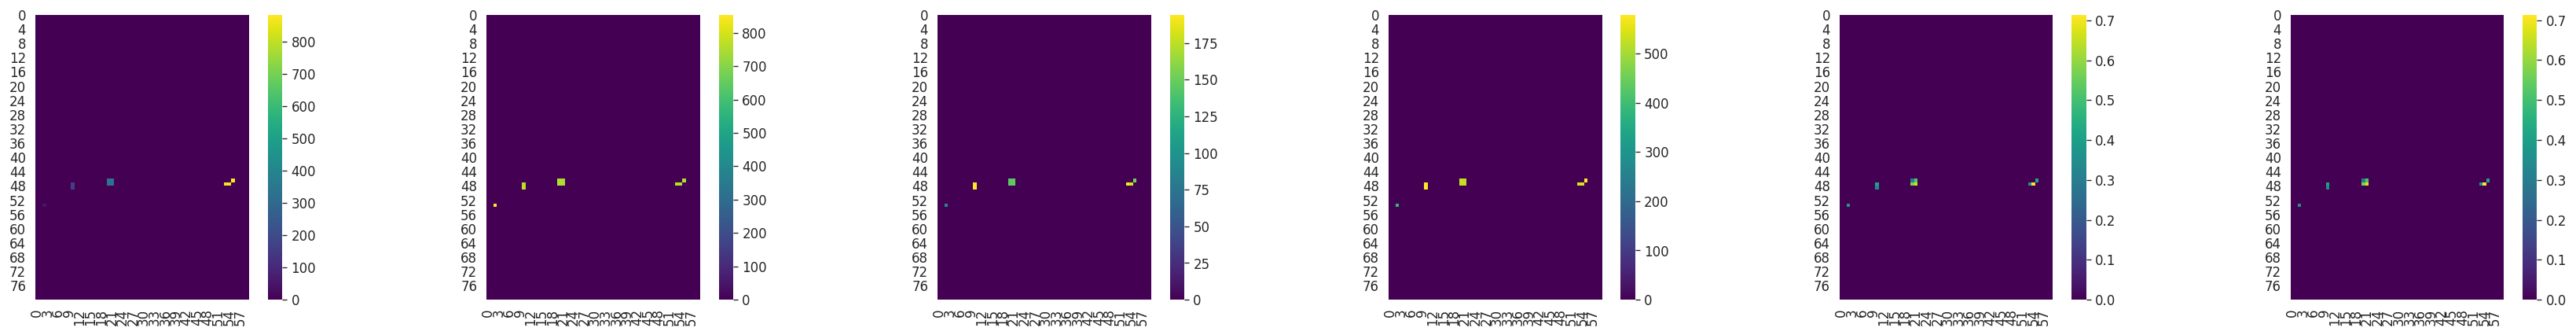

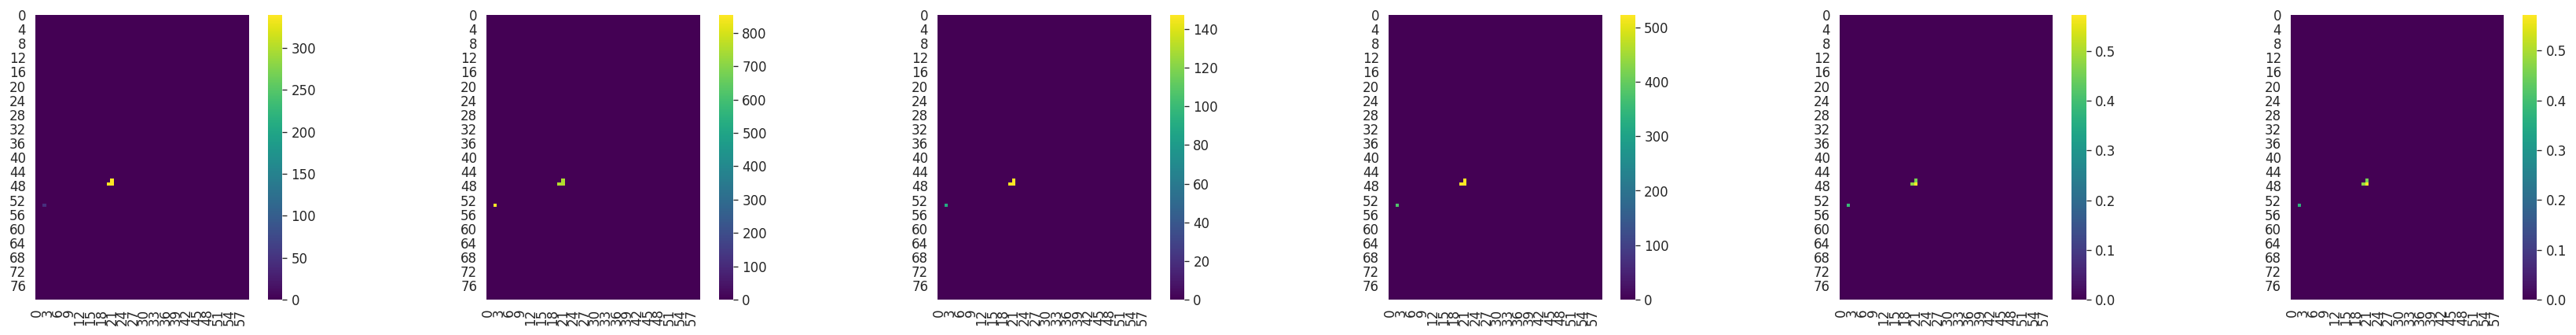

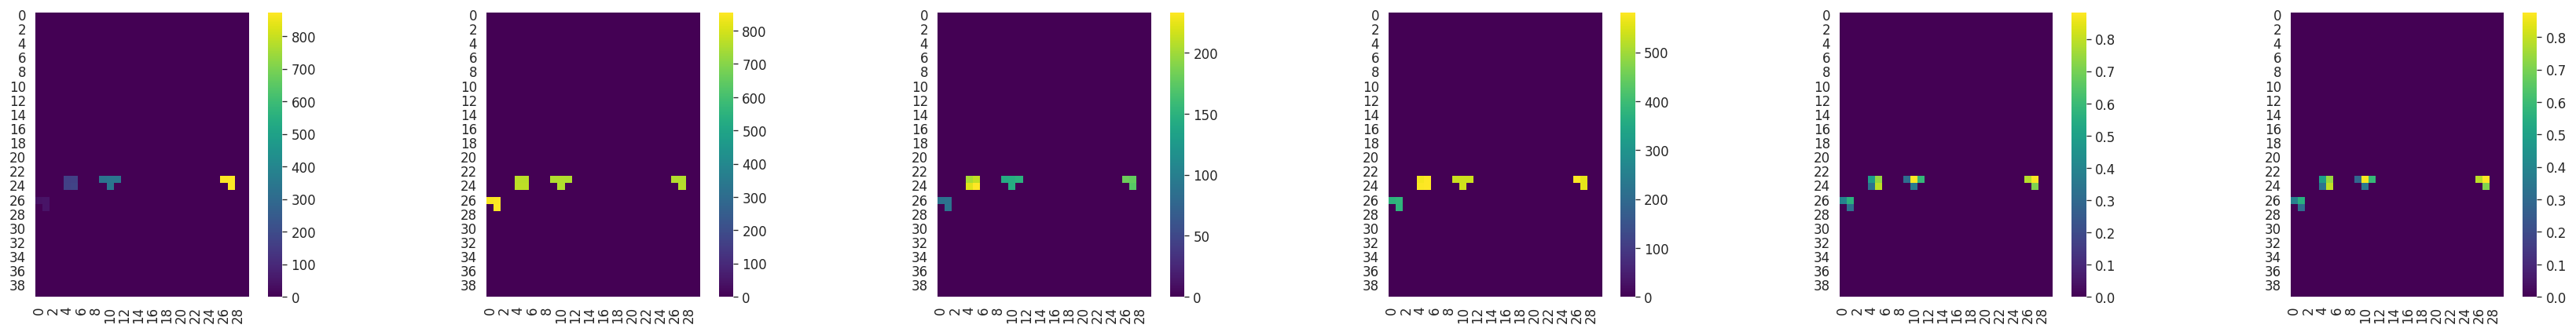

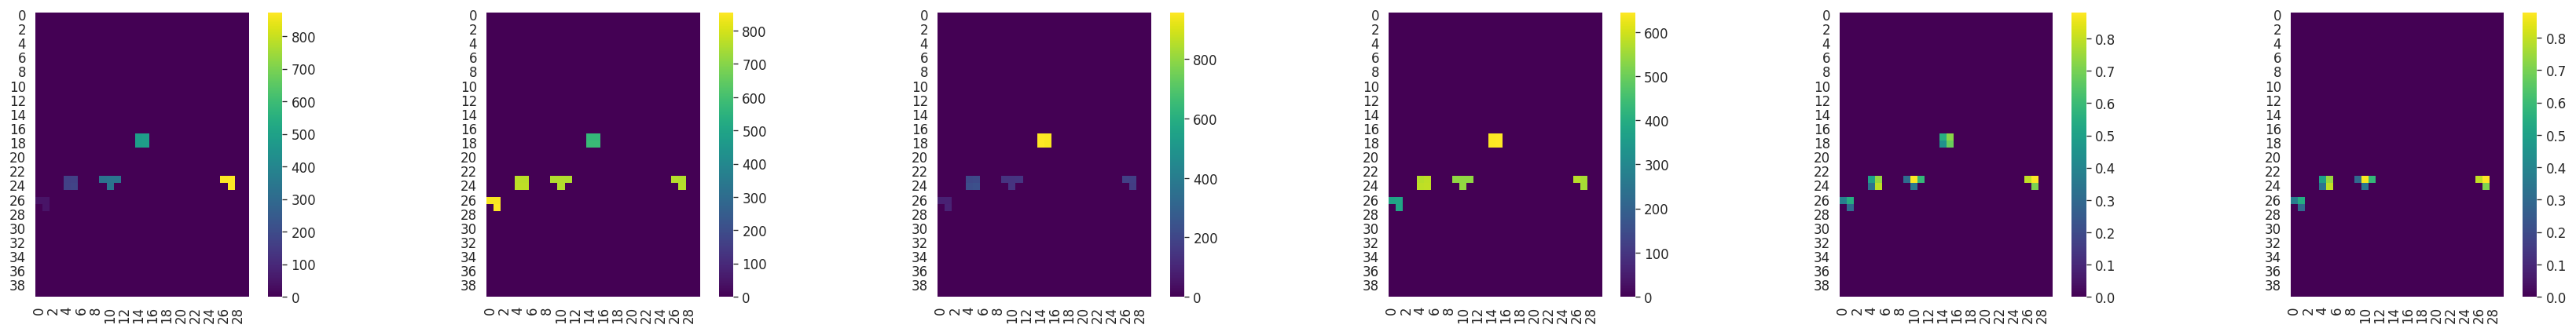

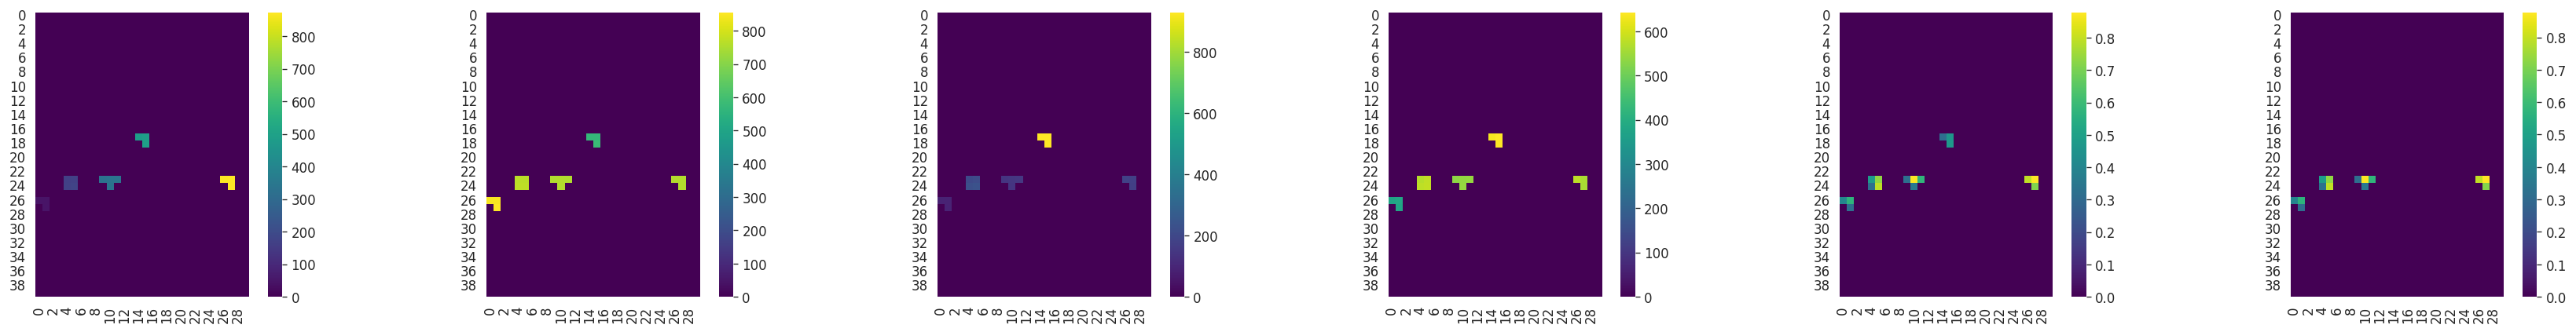

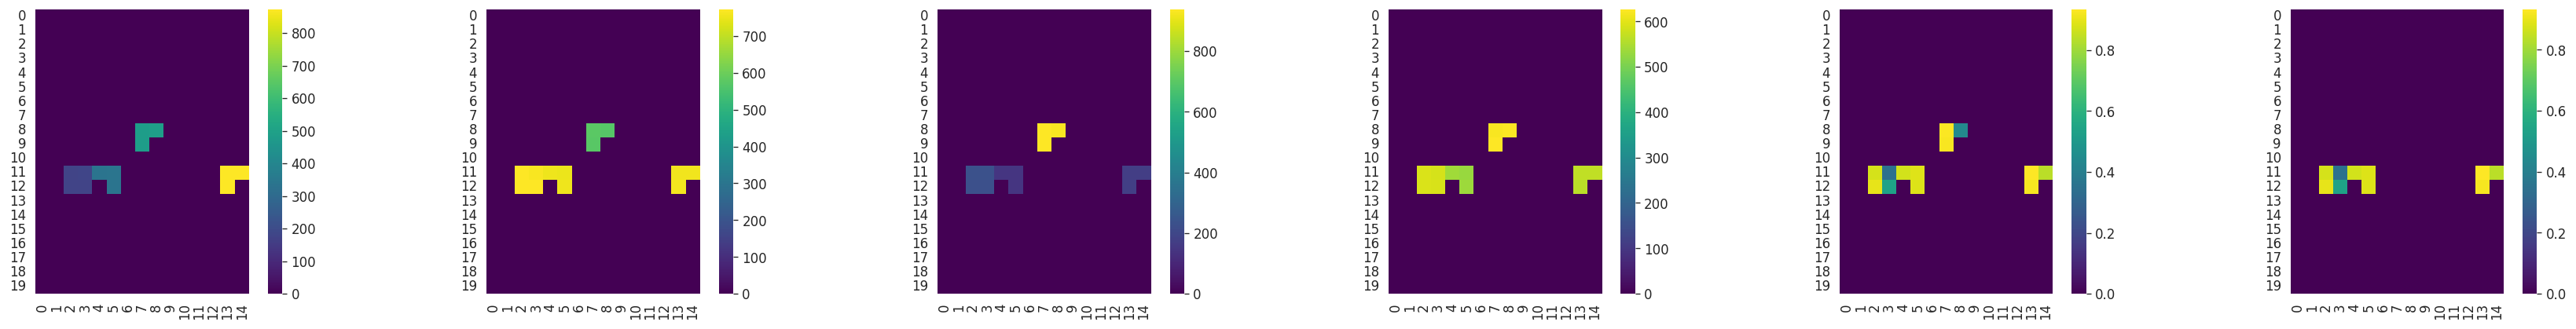

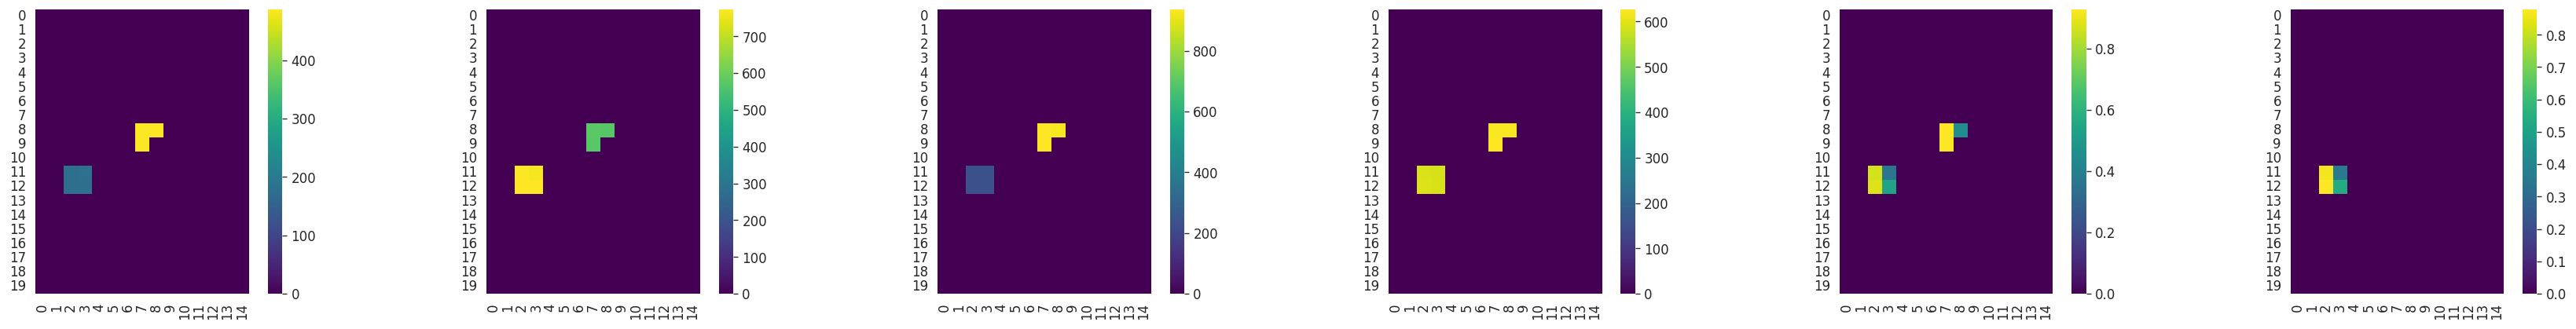

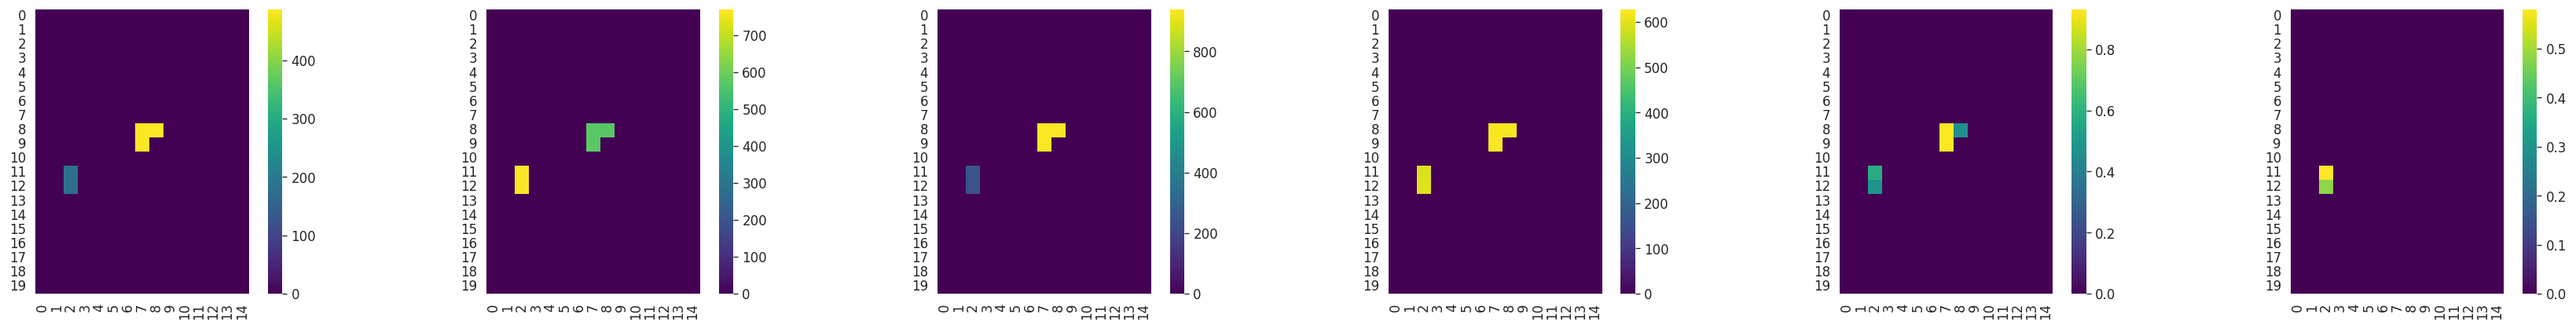

In [9]:
conf_threshold = 0.3
iou_threshold = 0.6
conf = [head[i][:, 4] for i in range(nl)]
# plot_single_heatmap(conf[3][2])
pr_filt = []
for i in range(nl):
    y = [torch.where(conf[i][j] < conf_threshold, 0, head[i][j]) for j in range(na)]
    filt_head = torch.ones([na] + list(y[0].shape), dtype=torch.float32, device=device)
    for j in range(na):
        filt_head[j] = y[j]
    pr_filt.append(filt_head)

# plot_single_heatmap(pr_filt[3][0,0])

for i in range(nl):
    pr_filt[i][pr_filt[i] < 0.01] = 0
    for j in range(na):
        pr_filt[i][j, 5:] *= pr_filt[i][j, 4]
        plot_multi_heatmap(*(pr_filt[i][j, k] for k in range(6)), col = 6)

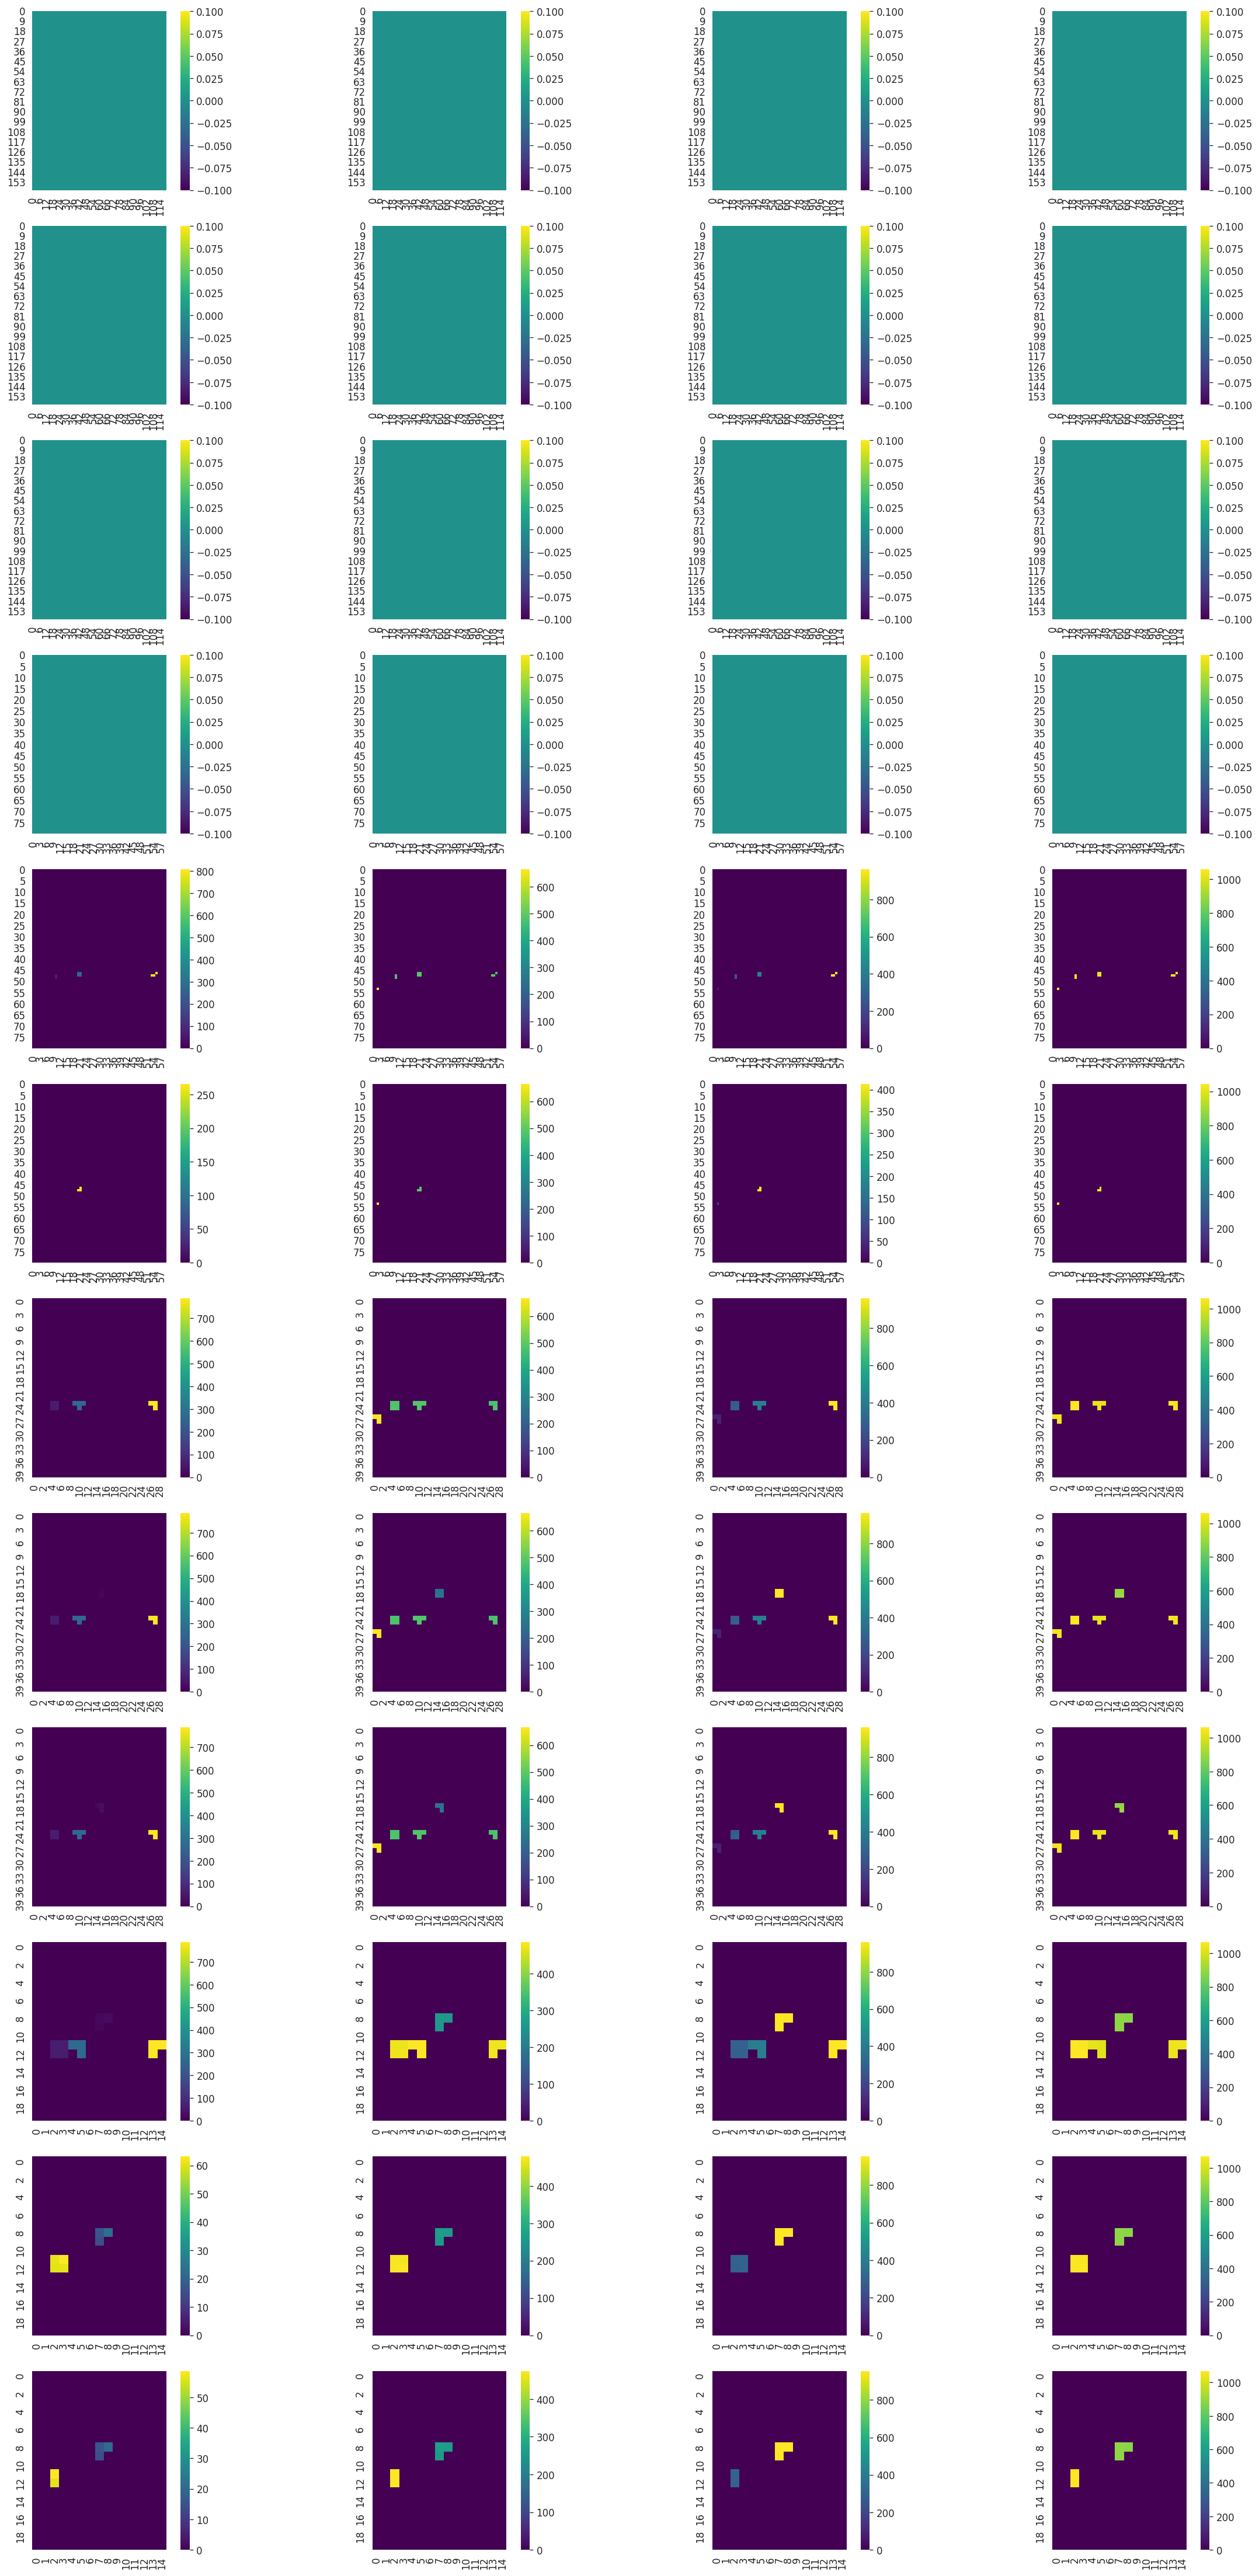

In [10]:
def xywh2xyxy(x):
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0, ...] = x[:, 0, ...] - x[:, 2, ...] / 2 # top left x
    y[:, 1, ...] = x[:, 1, ...] - x[:, 3, ...] / 2 # top left y
    y[:, 2, ...] = x[:, 0, ...] + x[:, 2, ...] / 2 # bottom right x
    y[:, 3, ...] = x[:, 1, ...] + x[:, 3, ...] / 2 # bottom right y
    return y
box = [xywh2xyxy(pr_filt[i][:, :4]) for i in range(nl)]
plot_multi_heatmap(*(box[i][j, k] for i in range(nl) for j in range(na) for k in range(4)), col=4)

In [11]:
cls_filt = list(pr_filt[i][:, 5:] for i in range(nl))
xyxycc = []
for i in range(nl):
    a, cls, gy, gx = torch.where(cls_filt[i] > conf_threshold)
    print(i)
    pr = cls_filt[i][a, cls, gy, gx]
    if len(pr):
        cls_filt[i] = torch.vstack([a, cls, gy, gx]).permute(1,0)
        xyxy = box[i][a, :4, gy, gx]
        xyxy = torch.hstack((xyxy, cls.view(-1,1), pr.view(-1,1)))
        print(xyxy.shape)
        xyxycc.append(xyxy)

xyxycc = torch.vstack(xyxycc)
xyxycc = xyxycc[torch.argsort(xyxycc[:, -1], descending=True)].cpu().numpy()
print(xyxycc)

0
1
torch.Size([14, 6])
2
torch.Size([47, 6])
3
torch.Size([25, 6])
[[     787.83      475.06      959.13      1041.2           0     0.93329]
 [     16.558      264.09      952.29      886.04           5     0.91911]
 [     14.093      258.38      953.48      886.49           5     0.91888]
 [     14.777      259.03      952.89      886.02           5     0.91888]
 [     787.03      477.92      959.66      1040.9           0     0.91883]
 [      15.55      263.59      954.08      886.05           5     0.91837]
 [     15.087      259.47      952.36       886.8           5     0.91669]
 [     16.774       264.5      952.21      886.03           5     0.91637]
 [     59.951         475      289.19      1067.1           0     0.89998]
 [     265.71      486.76      410.72      1016.4           0      0.8849]
 [     265.02      484.74       409.2      1020.4           0     0.88434]
 [     60.415      474.44      289.97      1067.6           0     0.87903]
 [     782.35      476.68      9

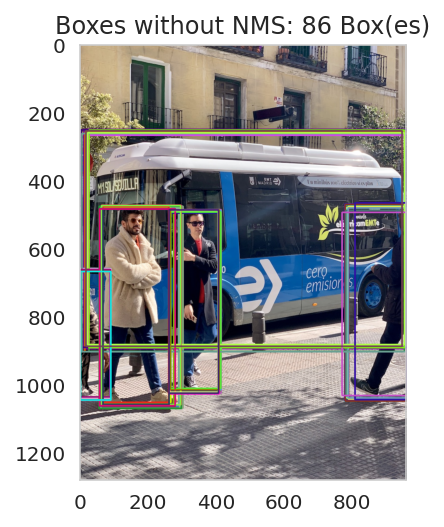

In [12]:
im1 = im0.copy()

for x1, y1, x2, y2 in xyxycc.round().astype(np.uint16)[..., :4]:
    cv.rectangle(im1, (x1, y1), (x2, y2), color=tuple(random.randint(0,255) for _ in range(3)) , thickness=4)

plt.title(f"Boxes without NMS: {xyxycc.shape[0]} Box(es)")
plot_single_image(im1)

In [13]:
def compute_area(x1y1x2y2):
    x1, y1, x2, y2 = x1y1x2y2.astype(np.float64)[:4]
    return (x2 - x1) * (y2 - y1)

def compute_intersection(xa1, xa2, xb1, xb2):
    assert xa1 <= xa2 and xb1 <= xb2, "x1 must <= x2"
    if xa1 > xb1:
        return compute_intersection(xb1, xb2, xa1, xa2)
    return min(max(xa2 - xb1, 0), xb2 - xb1)

def compute_iou(xyxy1, xyxy2):
    area_1, area_2 = compute_area(xyxy1), compute_area(xyxy2)
    x11, y11, x12, y12 = xyxy1.astype(np.float64)[:4]
    x21, y21, x22, y22 = xyxy2.astype(np.float64)[:4]

    x_in = compute_intersection(x11, x12, x21, x22)
    y_in = compute_intersection(y11, y12, y21, y22)
    area_intersection = x_in * y_in

    return area_intersection / (area_1 + area_2 - area_intersection)

def compute_diou(xyxy1, xyxy2):
    x11, y11, x12, y12 = xyxy1.astype(np.float64)[:4]
    x21, y21, x22, y22 = xyxy2.astype(np.float64)[:4]
    x_min, x_max = min(x11, x12), max(x12, x22)
    y_min, y_max = min(y11, y12), max(y12, y22)

    distance_p2 = ((x11 + x12 - x21 - x22) ** 2 + (y11 + y12 - y21 - y22) ** 2) / 4
    distance_c2 = (x_max - x_min) ** 2 + (y_max - y_min) ** 2

    return compute_iou(xyxy1, xyxy2) - distance_p2 / distance_c2

def nms(xyxy):
    from collections import deque
    stack = deque([0])
    keep = np.zeros(xyxy.shape[0], dtype=np.int8)
    keep[0] = 1
    while len(stack):
        k = stack.popleft()
        if keep[k] < 0:
            continue

        for j in np.where(keep[k+1:] >= 0)[0]:
            k0 = k + 1 + j
            # print(k, k0)
            if compute_iou(xyxy[k], xyxy[k0]) > iou_threshold:
                keep[k0] = -1
            else:
                stack.append(k0)
                keep[k0] = 1

        nms_xyxyc = xyxy[np.where(keep > 0)]

    return nms_xyxyc

nms_xyxyc = nms(xyxycc)

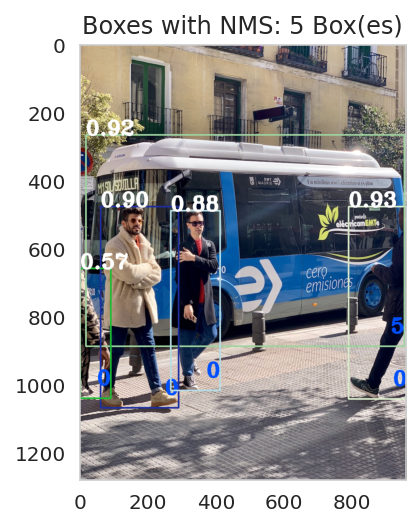

In [14]:
im1 = im0.copy()

for i in nms_xyxyc:
    x1, y1, x2, y2 = i[..., :4].round().astype(np.uint16)
    c = i[..., 4:]
    cv.rectangle(im1, (x1, y1), (x2, y2), color=tuple(random.randint(0,255) for _ in range(3)) , thickness=4)
    cv.putText(im1, f"{c[1]:.2f}", (x1,y1) ,thickness=6, color=(255, 255, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)
    cv.putText(im1, f"{c[0]:.0f}", (x2-40,y2-40) ,thickness=6, color=(0, 80, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)

plt.title(f"Boxes with NMS: {nms_xyxyc.shape[0]} Box(es)")
plot_single_image(im1)

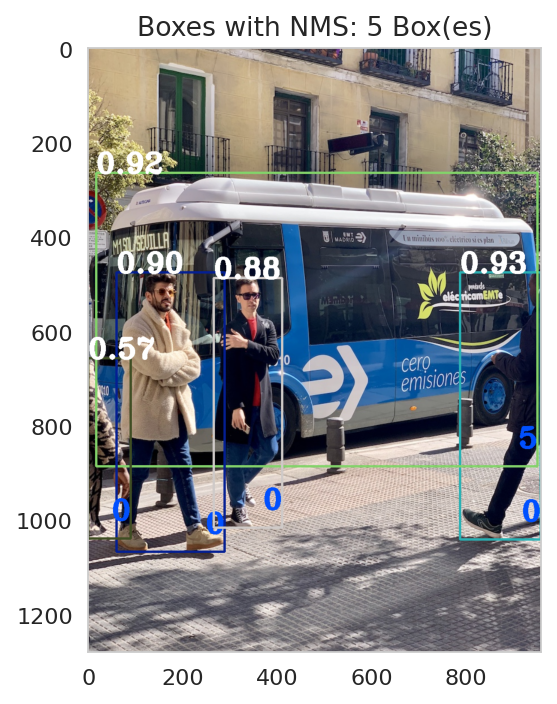

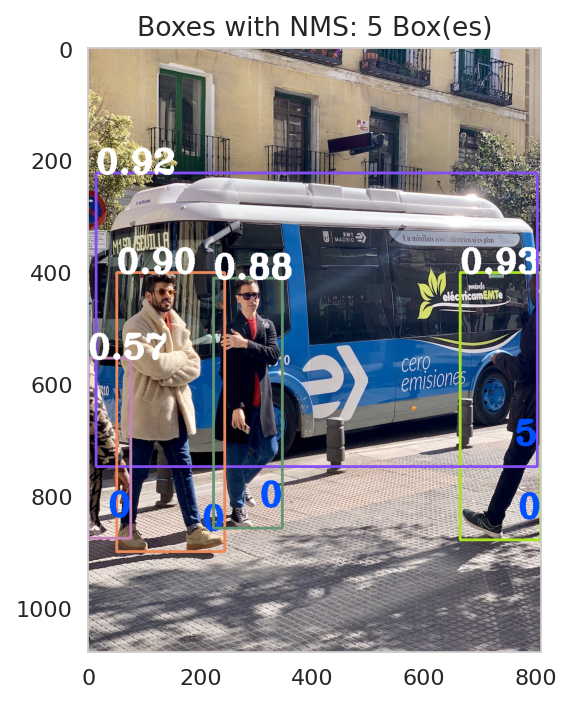

In [15]:
def clip_coords(boxes, shape):
    boxes[:, [0, 2]] = boxes[:, [0, 2]].clip(0, shape[1])  # x1, x2
    boxes[:, [1, 3]] = boxes[:, [1, 3]].clip(0, shape[0])  # y1, y2

# det[:, :4] = scale_coords(batch_inputs.shape[2:], det[:, :4], img_source.shape).round()
def my_scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]  # x padding
    coords[:, [1, 3]] -= pad[1]  # y padding
    coords[:, :4] /= gain
    clip_coords(coords, img0_shape)
    return coords

def plot_detect(prediction, batch_inputs, img_source, title=None):
    det = prediction.copy()
    det[:, :4] = my_scale_coords(batch_inputs.shape[2:], det[:, :4], img_source.shape).round()
    img_detect = img_source.copy()
    for i in det:
        x1, y1, x2, y2 = i[..., :4].round().astype(np.uint16)
        c = i[..., 4:]
        cv.rectangle(img_detect, (x1, y1), (x2, y2), color=tuple(random.randint(0,255) for _ in range(3)) , thickness=4)
        cv.putText(img_detect, f"{c[1]:.2f}", (x1,y1) ,thickness=6, color=(255, 255, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)
        cv.putText(img_detect, f"{c[0]:.0f}", (x2-40,y2-40) ,thickness=6, color=(0, 80, 255), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=2)
    plt.figure(figsize=(5, 5), dpi=80)
    # plot_single_image(im1)
    if title is not None:
        plt.title(title)
    plot_single_image(img_detect)

plot_detect(nms_xyxyc, batch_in, im0, title=f"Boxes with NMS: {nms_xyxyc.shape[0]} Box(es)")
plot_detect(nms_xyxyc, batch_in, img0, title=f"Boxes with NMS: {nms_xyxyc.shape[0]} Box(es)")

In [16]:
print("Multi-Class-Detection of All Anchors in all Heads have been already DONE!!!!")

Multi-Class-Detection of All Anchors in all Heads have been already DONE!!!!
